# Deterministic Finite Automaton Minimization

## Input format

    states number
    final states list
    states transitions by zero
    states transitions by one

#### Example

    8
    5 6
    7 7 4 4 5 5 6 2
    1 0 5 5 6 5 5 2

In [1]:
from graphviz import Digraph
from copy import deepcopy


class Automaton:
    def __init__(self, states=None, final_states=None, by_zero=None, by_one=None):
        self.states = states
        self.final_states = final_states
        self.by_zero = by_zero
        self.by_one = by_one

    def visualize(self):
        graph = Digraph()

        for state in self.states:
            if state in self.final_states:
                graph.node(name=str(state), label=str(state), shape='doublecircle')
            else:
                graph.node(name=str(state), label=str(state), shape='circle')

        for tail, head in zip(self.states, self.by_zero):
            graph.edge(tail_name=str(tail), head_name=str(head), label='0')

        for tail, head in zip(self.states, self.by_one):
            graph.edge(tail_name=str(tail), head_name=str(head), label='1')

        return graph


def read_automaton(input_file):
    automaton = Automaton()

    with open(input_file) as file:
        automaton.states = list(range(int(file.readline())))
        lines = []
        for line in file.readlines():
            lines.append([int(i) for i in line.split()])
        automaton.final_states, automaton.by_zero, automaton.by_one = lines

    return automaton


def get_equivalence_classes(automaton):
    equivalence_classes = []

    marked_states = []
    for state in automaton.states:
        if state in automaton.final_states:
            marked_states.append((1, (None, None)))  # (<class>, (<transition_by_zero_class>, <transition_by_one_class>))
        else:
            marked_states.append((0, (None, None)))

    old_classes_count = len(set(marked_states))

    while True:
        for state, state_marks in enumerate(marked_states):
            marked_states[state] = \
                (state_marks[0],
                 (marked_states[automaton.by_zero[state]][0], marked_states[automaton.by_one[state]][0]))

        unique_marks = list(set(marked_states))
        for state, state_marks in enumerate(marked_states):
            marked_states[state] = (unique_marks.index(state_marks), (None, None))

        if len(unique_marks) == old_classes_count:
            for equivalence_class in range(len(unique_marks)):
                equivalence_classes.append([state for state, state_marks in enumerate(marked_states)
                                           if state_marks[0] == equivalence_class])
            break

        old_classes_count = len(unique_marks)

    return equivalence_classes


def minimize_automaton(automaton, equivalence_classes):
    minimal_automaton = deepcopy(automaton)

    for equivalence_class in equivalence_classes:
        for state in equivalence_class:
            if minimal_automaton.by_zero[state] in equivalence_class:
                minimal_automaton.by_zero[state] = state
            else:
                minimal_automaton.by_zero[state] = \
                    min(equivalence_classes[[equivalence_classes.index(equivalence_class)
                                             for equivalence_class in equivalence_classes
                                             if minimal_automaton.by_zero[state] in equivalence_class][0]])
            if minimal_automaton.by_one[state] in equivalence_class:
                minimal_automaton.by_one[state] = state
            else:
                minimal_automaton.by_one[state] = \
                    min(equivalence_classes[[equivalence_classes.index(equivalence_class)
                                             for equivalence_class in equivalence_classes
                                             if minimal_automaton.by_one[state] in equivalence_class][0]])

    for equivalence_class in equivalence_classes:
        for state in equivalence_class[1:]:
            minimal_automaton.by_zero[state] = -1
            minimal_automaton.by_one[state] = -1
            if state in minimal_automaton.final_states:
                minimal_automaton.final_states.remove(state)
            minimal_automaton.states[minimal_automaton.states.index(state)] = -1

    not_deleted = lambda x: x != -1
    minimal_automaton.states = list(filter(not_deleted, minimal_automaton.states))
    minimal_automaton.by_zero = list(filter(not_deleted, minimal_automaton.by_zero))
    minimal_automaton.by_one = list(filter(not_deleted, minimal_automaton.by_one))

    for i, state in enumerate(minimal_automaton.states):
        if i < len(minimal_automaton.final_states):
            minimal_automaton.final_states[i] = minimal_automaton.states.index(minimal_automaton.final_states[i])
        minimal_automaton.by_zero[i] = minimal_automaton.states.index(minimal_automaton.by_zero[i])
        minimal_automaton.by_one[i] = minimal_automaton.states.index(minimal_automaton.by_one[i])
    minimal_automaton.states = list(range(len(minimal_automaton.states)))

    return minimal_automaton

## Random DFA generator

In [2]:
import random

def generate_test_dfa(states_number):
    final_states_number = random.randint(0, states_number - 1)
    final_states = [random.randint(0, states_number - 1) for i in range(final_states_number)]
    by_zero = [random.randint(0, states_number - 1) for i in range(states_number)]
    by_one = [random.randint(0, states_number - 1) for i in range(states_number)]
    test_data = str(states_number) + '\n' + ' '.join(str(v) for v in final_states) + '\n' + ' '.join(str(v) for v in by_zero) + '\n' + ' '.join(str(v) for v in by_one)
    with open('test_dfa.txt', 'w') as file:
        file.write(test_data)
    print('Test generated')


generate_test_dfa(5)

Test generated


#### Reading random DFA

In [3]:
initial_automaton = read_automaton('test_dfa.txt')

#### Reading DFA from file

In [4]:
initial_automaton = read_automaton('input.txt')

In [5]:
equivalence_classes = get_equivalence_classes(initial_automaton)
minimal_automaton = minimize_automaton(initial_automaton, equivalence_classes)

## Initial automaton

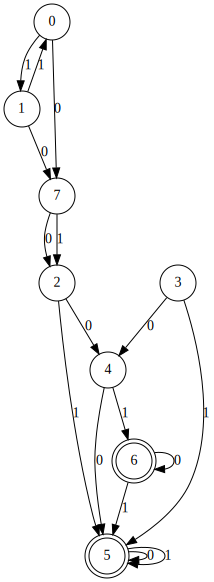

In [6]:
initial_automaton.visualize()

## Minimal automaton

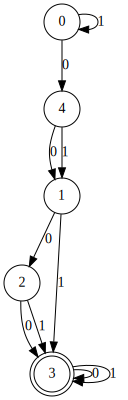

In [7]:
minimal_automaton.visualize()